In [2]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils, callbacks
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics



In [ ]:
from scipy.stats import wilcoxon, friedmanchisquare
import seaborn as sns

In [ ]:
train_folder = 'D:/Sougata/SHSMP_gesture/train'
all_data = []
for folder in os.listdir(train_folder):

    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

     label                                               path
0        a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_0...
1        a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_1...
2        a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_2...
3        a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_3...
4        a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_4...
...    ...                                                ...
3955     v  D:/Sougata/SHSMP_gesture/train/v/seq_11/frame_...
3956     v  D:/Sougata/SHSMP_gesture/train/v/seq_11/frame_...
3957     v  D:/Sougata/SHSMP_gesture/train/v/seq_11/frame_...
3958     v  D:/Sougata/SHSMP_gesture/train/v/seq_11/frame_...
3959     v  D:/Sougata/SHSMP_gesture/train/v/seq_11/frame_...

[3960 rows x 2 columns]


In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [ ]:
img_width, img_height = 64, 64
batch_size = 64
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 2772 validated image filenames belonging to 6 classes.
Found 673 validated image filenames belonging to 6 classes.
Found 514 validated image filenames belonging to 6 classes.


In [ ]:
# New Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

model5 = Sequential()

model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):

        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):

        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)


        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output


model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

# Define CASDPA mechanism (Context-Augmented Scaled Dot-Product Attention)
class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):

        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')


        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):

        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)


        query = tf.matmul(inputs, self.query_matrix)
        value = inputs


        score = tf.matmul(query, value, transpose_b=True)


        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)


        attention_weights = tf.nn.softmax(score, axis=-1)


        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention


model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_4 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_3 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module + CASDPA mechanism
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)


model5 = Sequential()

# Spatial Feature Extraction (CNN)
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):
        # Query matrix as a trainable weight
        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')

        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):
        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)  

        query = tf.matmul(inputs, self.query_matrix)
        value = inputs

        score = tf.matmul(query, value, transpose_b=True)

        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(score, axis=-1)

        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention

model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                                 patience=5, restore_best_weights=True)

classes = 6
epochs = 12
learning_rate = 0.0001

history5 = model5.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      shuffle=True, callbacks=[earlystopping])

Epoch 1/12
124/124 [==============================] - 53s 1s/step - loss: 1.3083 - accuracy: 0.2522 - val_loss: 1.3115 - val_accuracy: 0.2602
Epoch 2/12
124/124 [==============================] - 56s 2s/step - loss: 0.9502 - accuracy: 0.5058 - val_loss: 1.1181 - val_accuracy: 0.4035
Epoch 3/12
124/124 [==============================] - 58s 2s/step - loss: 0.8638 - accuracy: 0.5854 - val_loss: 0.8663 - val_accuracy: 0.5761
Epoch 4/12
124/124 [==============================] - 60s 3s/step - loss: 0.6243 - accuracy: 0.7274 - val_loss: 0.7058 - val_accuracy: 0.6690
Epoch 5/12
124/124 [==============================] - 62s 3s/step - loss: 0.3725 - accuracy: 0.8442 - val_loss: 0.4910 - val_accuracy: 0.7659
Epoch 6/12
124/124 [==============================] - 64s 4s/step - loss: 0.1700 - accuracy: 0.9080 - val_loss: 0.1725 - val_accuracy: 0.8987
Epoch 7/12
124/124 [==============================] - 66s 4s/step - loss: 0.0786 - accuracy: 0.9491 - val_loss: 0.0638 - val_accuracy: 0.9637
Epoch 

In [4]:
import time

sample_input = tf.random.normal((1, 64, 64, 3))  

start_time = time.time()
predictions = model5.predict(validation_generator)
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time, "seconds")

Inference Time: 11.057358458732569 seconds


In [5]:
import time

sample_input = np.random.rand(1, 64, 64, 3).astype(np.float32)

# Measure the time taken for prediction
start_time = time.time()
predictions = model5.predict(validation_generator)
end_time = time.time()

# Calculate latency in milliseconds
latency_ms = (end_time - start_time) * 1000
print("Latency (ms):", latency_ms)

Latency (ms): 10819.336587213654


In [6]:
# Total number of predictions made during the measurement
num_predictions = len(validation_generator) * batch_size  # Assuming batch_size is defined

throughput = num_predictions / (end_time - start_time)
print("Throughput (predictions/s):", throughput)

Throughput (predictions/s): 3715.756321785369


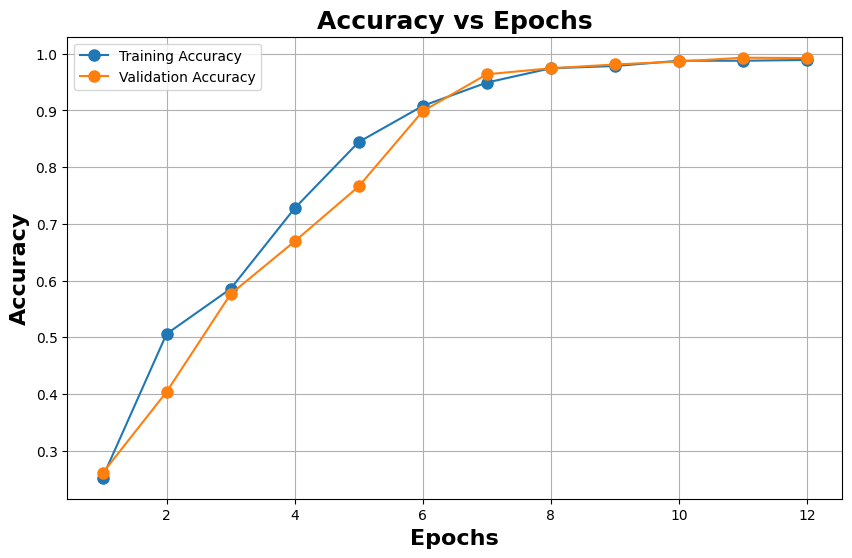

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], '-o', label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.title('Accuracy vs Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

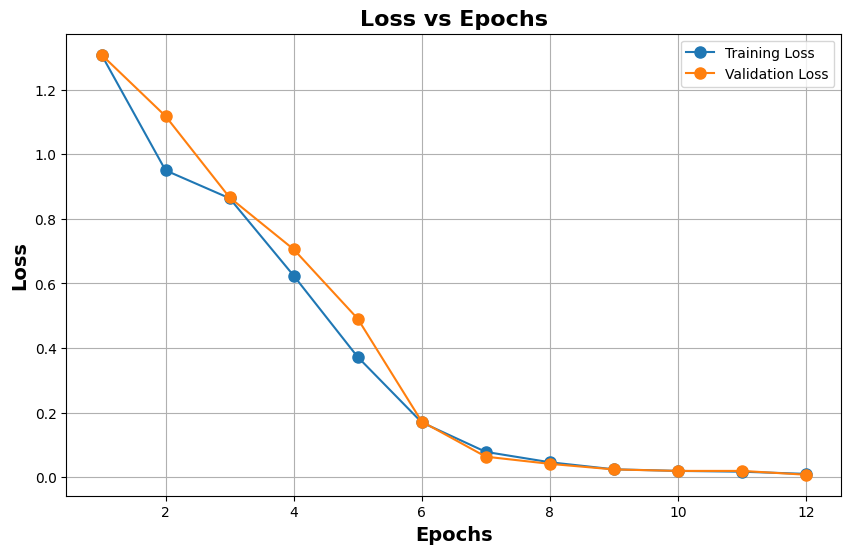

In [ ]:
# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], '-o', label='Training Loss')
plt.plot(history5.history['val_loss'], '-o', label='Validation Loss')
plt.title('Loss vs Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model3 = Sequential()

# Spatial Feature Extraction (CNN)
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model3.add(BatchNormalization())  
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model3.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model3.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model3.add(Flatten())  

# Classification Layer
model3.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN (None, 62, 62, 32)        128       
 ormalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2D (None, 31, 31, 32)        0         
 )                                                              
                                                                 
 spectral_conv2d (SpectralCo (None, 31, 31, 64)        18496     
 nv2D)                                                          
                                                                 
 polynomial_conv2d (Polynomi (None, 31, 31, 64)        36928     
 alConv2D)                                                 

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 6
epochs = 12
learning_rate = 0.0001

history3 = model3.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])


Epoch 1/12
124/124 [==============================] - 56s 1s/step - loss: 1.9456 - accuracy: 0.2721 - val_loss: 1.6547 - val_accuracy: 0.2735
Epoch 2/12
124/124 [==============================] - 58s 2s/step - loss: 1.5231 - accuracy: 0.5442 - val_loss: 1.1327 - val_accuracy: 0.4500
Epoch 3/12
124/124 [==============================] - 62s 2s/step - loss: 1.2840 - accuracy: 0.6491 - val_loss: 0.8086 - val_accuracy: 0.6133
Epoch 4/12
124/124 [==============================] - 59s 3s/step - loss: 0.8856 - accuracy: 0.8097 - val_loss: 0.7870 - val_accuracy: 0.7500
Epoch 5/12
124/124 [==============================] - 63s 4s/step - loss: 0.7370 - accuracy: 0.8759 - val_loss: 0.7222 - val_accuracy: 0.8575
Epoch 6/12
124/124 [==============================] - 65s 4s/step - loss: 0.6790 - accuracy: 0.9038 - val_loss: 0.5370 - val_accuracy: 0.9212
Epoch 7/12
124/124 [==============================] - 67s 5s/step - loss: 0.3754 - accuracy: 0.9237 - val_loss: 0.3812 - val_accuracy: 0.9637
Epoch 

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model4 = Sequential()

# Spatial Feature Extraction (CNN)
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model4.add(BatchNormalization())  
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model4.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model4.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Define an Inception module as a custom Keras layer
class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        # Define convolutional layers within the Inception module
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        # Define the different towers of the Inception module
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        # Concatenate the outputs of the towers to form the final output
        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

# Add the Inception module
model4.add(InceptionModule(filters=64))

model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())  

# Classification Layer
model4.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_5 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_4 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 6
epochs = 12
learning_rate = 0.0001

history4 = model4.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Epoch 1/12
124/124 [==============================] - 56s 1s/step - loss: 1.8506 - accuracy: 0.4035 - val_loss: 1.3688 - val_accuracy: 0.2854
Epoch 2/12
124/124 [==============================] - 58s 2s/step - loss: 1.4816 - accuracy: 0.6066 - val_loss: 1.3828 - val_accuracy: 0.3597
Epoch 3/12
124/124 [==============================] - 61s 2s/step - loss: 1.0619 - accuracy: 0.7513 - val_loss: 0.5420 - val_accuracy: 0.5164
Epoch 4/12
124/124 [==============================] - 63s 3s/step - loss: 0.6679 - accuracy: 0.8257 - val_loss: 0.3304 - val_accuracy: 0.6053
Epoch 5/12
124/124 [==============================] - 65s 4s/step - loss: 0.4304 - accuracy: 0.8894 - val_loss: 0.3059 - val_accuracy: 0.7473
Epoch 6/12
124/124 [==============================] - 66s 4s/step - loss: 0.3468 - accuracy: 0.9146 - val_loss: 0.2372 - val_accuracy: 0.8788
Epoch 7/12
124/124 [==============================] - 68s 4s/step - loss: 0.2321 - accuracy: 0.9292 - val_loss: 0.1951 - val_accuracy: 0.9199
Epoch 

In [1]:
# New Model with CNN + spectral CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model2 = Sequential()

# Spatial Feature Extraction (CNN)
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model2.add(BatchNormalization())  
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model2.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model2.add(Flatten())  

# Classification Layer
model2.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model2.summary())


earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 6
epochs = 12
learning_rate = 0.0001

history2 = model2.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_1 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 flatten_3 (Flatten)         (None, 61504)             0         
                                                         

## Apply Wilcoxon Signed-Rank Test

In [ ]:
from scipy.stats import wilcoxon
import numpy as np

# Assuming 'holdout_generator' contains the test data
y_true = holdout_generator.classes  

# Generate predictions from model1 
y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)  

# Generate predictions from model5
y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)  

# Wilcoxon signed-rank test between model1 and model5 predictions
statistic, p_value = wilcoxon(y_pred_model1, y_pred_model5)

# Calculate Z-statistic (since Wilcoxon produces W-statistic)
z_statistic = (statistic - (len(y_pred_model1) * (len(y_pred_model1) + 1)) / 4) / np.sqrt((len(y_pred_model1) * (len(y_pred_model1) + 1) * (2 * len(y_pred_model1) + 1)) / 24)

# Calculate Effect Size (r), where r = Z / sqrt(n)
effect_size = z_statistic / np.sqrt(len(y_pred_model1))

# Print results
print(f"Wilcoxon p-value: {p_value:.3f}")
print(f"Z-Statistic: {z_statistic:.2f}")
print(f"Effect Size: {effect_size:.2f}")

Wilcoxon p-value: 0.021
Z-Statistic: -2.31
Effect Size: 0.39


## Apply Friedman Test

In [ ]:
from scipy.stats import friedmanchisquare, rankdata
import numpy as np

y_true = holdout_generator.classes

y_pred_probs_model3 = model2.predict(holdout_generator)
y_pred_model3 = np.argmax(y_pred_probs_model3, axis=1)

y_pred_probs_model2 = model3.predict(holdout_generator)
y_pred_model2 = np.argmax(y_pred_probs_model2, axis=1)

y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)

y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)


# Friedman Test
friedman_stat, friedman_p_value = friedmanchisquare(y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3)

# Print Chi-Square Statistic (χ²)
print(f"Chi-Square Statistic (χ²): {friedman_stat:.2f}")


k = 4  
df = k - 1  
print(f"Degrees of Freedom (df): {df}")

# Calculate Sum of Squares (SS)
data = np.array([y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3]).T
ranks = np.apply_along_axis(rankdata, 1, data)
mean_ranks = np.mean(ranks, axis=0)
overall_mean_rank = np.mean(mean_ranks)

N = len(y_true)

SS_total = N * np.sum((mean_ranks - overall_mean_rank) ** 2)
print(f"Sum of Squares (SS): {SS_total:.2f}")

MS = SS_total / df
print(f"Mean Square (MS): {MS:.3f}")

print(f"p-value: {friedman_p_value:.3f}")

Chi-Square Statistic (χ²): 11.25
Degrees of Freedom (df): 3
Sum of Squares (SS): 15.36
Mean Square (MS): 5.12
p-value: 0.0143
